In [1]:
from fastai.tabular.all import *
set_seed(42)
from warnings import simplefilter
set_seed(42)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
mixed_type = [98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730]
for column in mixed_type:
    df[df.columns[column]] = pd.to_numeric(df[df.columns[column]], errors='coerce')
df.replace(to_replace='.', value=np.nan, inplace=True)
df.replace(regex='^[.;]+$', value=np.nan, inplace=True)
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)




/tmp/ipykernel_20168/4039863829.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


In [3]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
df_data = df.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df.select_dtypes(include=[np.number]).replace(to_replace=np.nan, value=0, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [5]:
dls = to.dataloaders(bs=1024)

In [20]:
classes = {0: 1, 1: 1, 2: 2, 3: 2, 4: 3}

class GroupLoss(nn.Module):
    def __init__(self, gamma = 2.0):
        super(GroupLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inp, targ):
        sm_acts = torch.softmax(inp, dim=1)
        losses = []
        for i in range(len(targ)):
            target_class = classes[targ[i].item()]
            pred_class = sm_acts[i].argmax().item()
            if target_class != classes[pred_class]:
                losses.append(torch.pow(1 - sm_acts[i][targ[i].item()], self.gamma) * torch.log(sm_acts[i][targ[i].item()]) * 3)
            else:
                losses.append(torch.pow(1 - sm_acts[i][targ[i].item()], self.gamma) * torch.log(sm_acts[i][targ[i].item()]))
      
        return -torch.stack(losses).mean()

def accuracy_pen(input, target):
    sm_acts = torch.softmax(input, dim=1)
    preds = sm_acts.argmax(dim=1)
    preds_class = [classes[pred.item()] for pred in preds]
    targ_class = [classes[t.item()] for t in target]
    return (torch.tensor(preds_class) == torch.tensor(targ_class)).float().mean()
   

In [21]:
learn = tabular_learner(dls, metrics=accuracy_pen, loss_func=GroupLoss(gamma=4))

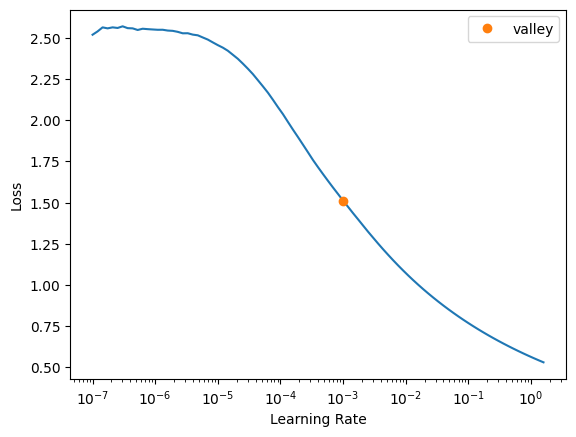

In [22]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy_pen,time
0,2.622655,2.800794,0.199759,00:02
1,1.828138,2.793796,0.241877,00:02
2,1.408194,2.794479,0.253911,00:02
3,1.143247,2.751039,0.261131,00:01
4,0.945781,2.650087,0.270758,00:01
5,0.785762,2.484035,0.283995,00:01
6,0.662962,1.827735,0.552347,00:01
7,0.567353,1.374648,0.742479,00:01
8,0.491343,1.195230,0.784597,00:02
9,0.429781,1.064461,0.808664,00:01


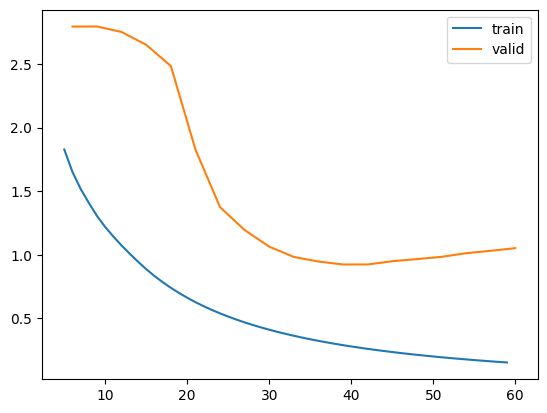

In [18]:
learn.fit(20, lr, 1e-3)
learn.recorder.plot_loss()

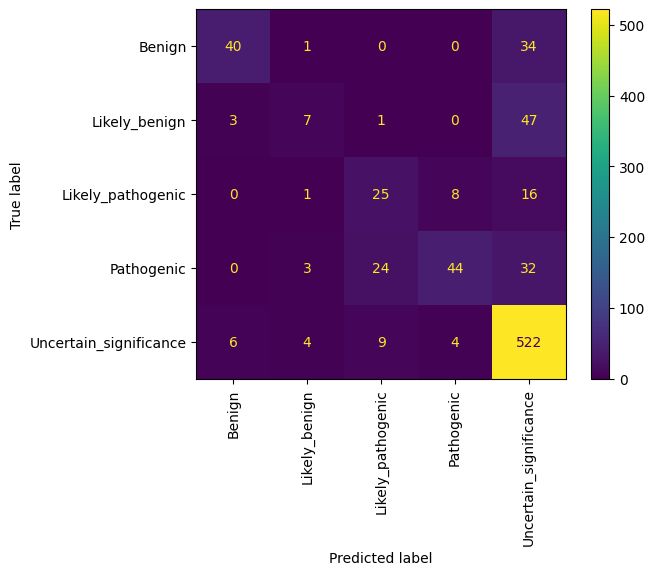

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds, targets = learn.get_preds(ds_idx=1)
pred_classes = np.argmax(preds, axis=1)

# Flattening delle etichette di classe
true_classes = targets.squeeze().numpy()

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

In [14]:
test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.cancer.tsv', sep='\t')
mixed_type = [98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730]
for column in mixed_type:
    test_df[test_df.columns[column]] = pd.to_numeric(test_df[test_df.columns[column]], errors='coerce')
test_df.replace(to_replace='.', value=np.nan, inplace=True)
test_df.replace(regex='^[.;]+$', value=np.nan, inplace=True)
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
#targets = test_df.pop('clinvar_clnsig')
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)

/tmp/ipykernel_20168/208669869.py:1: DtypeWarning: Columns (650,651,681,682,684,685,717) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.cancer.tsv', sep='\t')


(#2) [0.7393926382064819,0.9408758878707886]

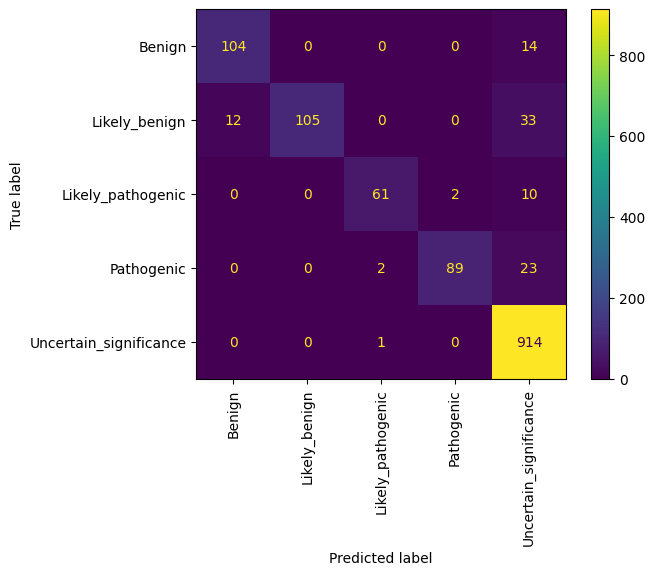

In [15]:
preds, targets = learn.get_preds(dl=test_dl)
pred_classes = np.argmax(preds, axis=1)

# Flattening delle etichette di classe
true_classes = targets.squeeze().numpy()

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')